## Kinaret 2D vs 3D Carbon Nanomaterials Analysis

In [1]:
"""
OBJECTIVE 1: Compare 2D vs 3D Carbon Nanomaterials in THP-1 Cells
Kinaret GSE92901 Dataset

This notebook compares:
- 2D Graphene (SES) vs Control
- 3D Fullerene vs Control
- Direct comparison of 2D vs 3D effects

All in the SAME cell type (THP-1 macrophages)
"""

# Install required packages (run once)
!pip install gseapy GEOparse matplotlib seaborn scipy matplotlib-venn -q

# Import libraries
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import GEOparse
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 kB 16.8 MB/s eta 0:00:00
✅ All packages imported successfully!


Cell 2: Load Kinaret Data

In [3]:
print("="*60)
print("LOADING KINARET GSE92901 DATA")
print("="*60)

# Download data from GEO
gse = GEOparse.get_GEO("GSE92901", destdir="./geo_data")
gpl = GEOparse.get_GEO(geo="GPL10332", destdir="./geo_data")

print(f"✅ Loaded GSE92901: {len(gse.gsms)} samples")

12-Nov-2025 19:34:31 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE92nnn/GSE92901/soft/GSE92901_family.soft.gz to ./geo_data/GSE92901_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE92nnn/GSE92901/soft/GSE92901_family.soft.gz to ./geo_data/GSE92901_family.soft.gz


LOADING KINARET GSE92901 DATA


100%|██████████| 37.5M/37.5M [00:12<00:00, 3.13MB/s]
12-Nov-2025 19:34:44 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
12-Nov-2025 19:34:44 DEBUG downloader - Moving /tmp/tmp096tmofe to /content/geo_data/GSE92901_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp096tmofe to /content/geo_data/GSE92901_family.soft.gz
12-Nov-2025 19:34:44 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE92nnn/GSE92901/soft/GSE92901_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE92nnn/GSE92901/soft/GSE92901_family.soft.gz
12-Nov-2025 19:34:44 INFO GEOparse - Parsing ./geo_data/GSE92901_family.soft.gz: 
INFO:GEOparse:Parsing ./geo_data/GSE92901_family.soft.gz: 
12-Nov-2025 19:34:44 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
12-Nov-2025 19:34:44 DEBUG GEOparse - SERIES: GSE92901
DEBUG:GEOparse:SERIES: GSE92901
12-Nov-2025 19:34:44 DEBUG GEOparse - PLATFORM: GPL10332
DEBU

✅ Loaded GSE92901: 72 samples


Cell 3: Extract Sample Metadata

In [4]:
# Extract sample metadata
sample_metadata = []
for gsm_name, gsm in gse.gsms.items():
    title = gsm.metadata.get("title", ["Unknown"])[0]
    parts = title.split(".")

    if len(parts) >= 3:
        treatment = parts[0]
        timepoint = parts[1]
        replicate = parts[2]
    else:
        treatment = title
        timepoint = "unknown"
        replicate = "1"

    sample_metadata.append({
        "GSM": gsm_name,
        "title": title,
        "treatment": treatment,
        "timepoint": timepoint,
        "replicate": replicate
    })

meta_df = pd.DataFrame(sample_metadata)

print("Available treatments:")
print(meta_df.groupby(['treatment', 'timepoint']).size())

Available treatments:
treatment        timepoint
10_id_SES        unknown      1
11_id_SES        unknown      1
12_id_SES        unknown      1
13_id_Graphite   unknown      1
14_id_Graphite   unknown      1
15_id_Graphite   unknown      1
16_id_Graphite   unknown      1
17_id_BayTubes   unknown      1
18_id_BayTubes   unknown      1
19_id_BayTubes   unknown      1
1_id_Ctrl        unknown      1
20_id_BayTubes   unknown      1
21_id_fullerene  unknown      1
22_id_fullerene  unknown      1
23_id_fullerene  unknown      1
24_id_fullerene  unknown      1
2_id_Ctrl        unknown      1
3_id_Ctrl        unknown      1
4_id_rCNT        unknown      1
5_id_rCNT        unknown      1
6_id_rCNT        unknown      1
7_id_tCNT        unknown      1
8_id_tCNT        unknown      1
9_id_tCNT        unknown      1
Baytube          24h          3
                 6h           3
Fullerene        24h          3
                 6h           3
Graphite         24h          3
                 6h    

Cell 4: Verify Cell Type

In [5]:
print("="*60)
print("CELL TYPE VERIFICATION")
print("="*60)

sample = list(gse.gsms.values())[0]
print("Sample characteristics:")
for char in sample.metadata.get('characteristics_ch1', []):
    print(f"  {char}")

print("\n✅ Confirmed: THP-1 macrophages")

CELL TYPE VERIFICATION
Sample characteristics:
  cell line: THP-1
  differentiation status: macrophages
  exposure: 100 ug of CNM in 1ml of RPMI medium
  exposure method: differentiated THP-1 cells in culture
  time: 24

✅ Confirmed: THP-1 macrophages


Cell 5: Extract Expression Data

In [6]:
print("="*60)
print("EXTRACTING EXPRESSION DATA")
print("="*60)

# Get expression data from each sample
expr_dfs = []
for gsm_name, gsm in gse.gsms.items():
    sample_expr = gsm.table[["ID_REF", "VALUE"]].copy()
    sample_expr.columns = ["ProbeID", gsm_name]
    expr_dfs.append(sample_expr)

# Merge all samples
expr_matrix = expr_dfs[0]
for df in expr_dfs[1:]:
    expr_matrix = expr_matrix.merge(df, on="ProbeID", how="outer")

print(f"✅ Expression matrix: {expr_matrix.shape}")
print(f"   Probes: {expr_matrix.shape[0]}")
print(f"   Samples: {expr_matrix.shape[1] - 1}")

EXTRACTING EXPRESSION DATA
✅ Expression matrix: (62976, 73)
   Probes: 62976
   Samples: 72


Cell 6: Map Probes to Gene Symbols

In [7]:
print("="*60)
print("MAPPING PROBES TO GENE SYMBOLS")
print("="*60)

# Extract gene mapping
gpl_table = gpl.table
gpl_genes = gpl_table[~gpl_table["GENE_SYMBOL"].isna()].copy()
gene_map = gpl_genes[["ID", "GENE_SYMBOL"]].copy()
gene_map.columns = ["ProbeID", "GeneSymbol"]
gene_map = gene_map[gene_map["GeneSymbol"].str.strip() != ""]

print(f"✅ Gene mapping: {len(gene_map)} probes with symbols")

# Merge and collapse to genes
expr_reset = expr_matrix.rename(columns={"ProbeID": "ID"})
merged = expr_reset.merge(gene_map.rename(columns={"ProbeID": "ID"}), on="ID", how="inner")
merged = merged.dropna(subset=["GeneSymbol"])
expr_by_gene = merged.groupby("GeneSymbol").mean(numeric_only=True)

print(f"✅ Gene-level expression: {expr_by_gene.shape}")
print(f"   Genes: {expr_by_gene.shape[0]}")
print(f"   Samples: {expr_by_gene.shape[1]}")

MAPPING PROBES TO GENE SYMBOLS
✅ Gene mapping: 38422 probes with symbols
✅ Gene-level expression: (22682, 73)
   Genes: 22682
   Samples: 73


Cell 7: Comparison 1 - 2D Graphene vs Control

In [8]:
print("="*60)
print("COMPARISON 1: 2D GRAPHENE (SES) vs CONTROL")
print("="*60)

# Extract samples
negCont_24h = meta_df.query("treatment == 'negCont' and timepoint == '24h'").index.tolist()
SES_24h = meta_df.query("treatment == 'SES' and timepoint == '24h'").index.tolist()

# Get sample names
negCont_samples = meta_df.loc[negCont_24h, 'GSM'].tolist()
SES_samples = meta_df.loc[SES_24h, 'GSM'].tolist()

print(f"Control samples (n={len(negCont_samples)}): {negCont_samples}")
print(f"SES/Graphene samples (n={len(SES_samples)}): {SES_samples}")

# Subset expression data
subset_ses = expr_by_gene[negCont_samples + SES_samples]

# Calculate t-statistics
grp_control_ses = subset_ses[negCont_samples]
grp_SES = subset_ses[SES_samples]

m_control_ses = grp_control_ses.mean(axis=1)
m_SES = grp_SES.mean(axis=1)

v_control_ses = grp_control_ses.var(axis=1)
v_SES = grp_SES.var(axis=1)

n_control_ses = grp_control_ses.shape[1]
n_SES = grp_SES.shape[1]

# Welch t-statistic (positive = UP in graphene)
tstat_ses = (m_SES - m_control_ses) / np.sqrt(
    v_SES/n_SES + v_control_ses/n_control_ses + 1e-12
)

# Create ranked list
rnk_ses = pd.DataFrame({
    "gene": subset_ses.index,
    "score": tstat_ses
}).dropna()

# Handle duplicates
rnk_ses = rnk_ses.loc[rnk_ses.groupby("gene")["score"].apply(lambda s: s.abs().idxmax())]
rnk_ses = rnk_ses.sort_values("score", ascending=False)

print(f"\n✅ 2D Graphene ranked list: {len(rnk_ses)} genes")
print(f"   Top upregulated: {rnk_ses.iloc[0]['gene']} (t={rnk_ses.iloc[0]['score']:.2f})")
print(f"   Top downregulated: {rnk_ses.iloc[-1]['gene']} (t={rnk_ses.iloc[-1]['score']:.2f})")

# Save
rnk_ses.to_csv("kinaret_2D_graphene_vs_control.rnk", sep="\t", header=False, index=False)
print("✅ Saved: kinaret_2D_graphene_vs_control.rnk")

COMPARISON 1: 2D GRAPHENE (SES) vs CONTROL
Control samples (n=6): ['GSM2439566', 'GSM2439568', 'GSM2439588', 'GSM2439590', 'GSM2439598', 'GSM2439605']
SES/Graphene samples (n=3): ['GSM2439561', 'GSM2439591', 'GSM2439600']

✅ 2D Graphene ranked list: 22682 genes
   Top upregulated: HEPH (t=8.25)
   Top downregulated: DNAJC3 (t=-7.63)
✅ Saved: kinaret_2D_graphene_vs_control.rnk


Cell 8: Comparison 2 - 3D Fullerene vs Control

In [9]:
print("="*60)
print("COMPARISON 2: 3D FULLERENE vs CONTROL")
print("="*60)

# Extract samples
Fullerene_24h = meta_df.query("treatment == 'Fullerene' and timepoint == '24h'").index.tolist()
Fullerene_samples = meta_df.loc[Fullerene_24h, 'GSM'].tolist()

print(f"Control samples (n={len(negCont_samples)}): {negCont_samples}")
print(f"Fullerene samples (n={len(Fullerene_samples)}): {Fullerene_samples}")

# Subset expression data
subset_full = expr_by_gene[negCont_samples + Fullerene_samples]

# Calculate t-statistics
grp_control_full = subset_full[negCont_samples]
grp_Fullerene = subset_full[Fullerene_samples]

m_control_full = grp_control_full.mean(axis=1)
m_Fullerene = grp_Fullerene.mean(axis=1)

v_control_full = grp_control_full.var(axis=1)
v_Fullerene = grp_Fullerene.var(axis=1)

n_control_full = grp_control_full.shape[1]
n_Fullerene = grp_Fullerene.shape[1]

# Welch t-statistic (positive = UP in fullerene)
tstat_full = (m_Fullerene - m_control_full) / np.sqrt(
    v_Fullerene/n_Fullerene + v_control_full/n_control_full + 1e-12
)

# Create ranked list
rnk_full = pd.DataFrame({
    "gene": subset_full.index,
    "score": tstat_full
}).dropna()

# Handle duplicates
rnk_full = rnk_full.loc[rnk_full.groupby("gene")["score"].apply(lambda s: s.abs().idxmax())]
rnk_full = rnk_full.sort_values("score", ascending=False)

print(f"\n✅ 3D Fullerene ranked list: {len(rnk_full)} genes")
print(f"   Top upregulated: {rnk_full.iloc[0]['gene']} (t={rnk_full.iloc[0]['score']:.2f})")
print(f"   Top downregulated: {rnk_full.iloc[-1]['gene']} (t={rnk_full.iloc[-1]['score']:.2f})")

# Save
rnk_full.to_csv("kinaret_3D_fullerene_vs_control.rnk", sep="\t", header=False, index=False)
print("✅ Saved: kinaret_3D_fullerene_vs_control.rnk")

COMPARISON 2: 3D FULLERENE vs CONTROL
Control samples (n=6): ['GSM2439566', 'GSM2439568', 'GSM2439588', 'GSM2439590', 'GSM2439598', 'GSM2439605']
Fullerene samples (n=3): ['GSM2439572', 'GSM2439578', 'GSM2439599']

✅ 3D Fullerene ranked list: 22682 genes
   Top upregulated: NUPR1 (t=12.16)
   Top downregulated: DAAM1 (t=-7.37)
✅ Saved: kinaret_3D_fullerene_vs_control.rnk


Cell 9: Run GSEA - 2D Graphene

In [10]:
print("="*60)
print("RUNNING GSEA: 2D GRAPHENE")
print("="*60)

gsea_2d = gp.prerank(
    rnk="kinaret_2D_graphene_vs_control.rnk",
    gene_sets="MSigDB_Hallmark_2020",
    outdir="gsea_kinaret_2D_graphene",
    min_size=15,
    max_size=500,
    permutation_num=1000,
    seed=42,
    threads=4,
    format="png",
    verbose=True
)

print("✅ GSEA complete for 2D Graphene")

2025-11-12 19:38:23,825 [INFO] Parsing data files for GSEA.............................


RUNNING GSEA: 2D GRAPHENE


2025-11-12 19:38:24,515 [INFO] Downloading and generating Enrichr library gene sets......
2025-11-12 19:38:25,702 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=15
2025-11-12 19:38:25,705 [INFO] 0050 gene_sets used for further statistical testing.....
2025-11-12 19:38:25,707 [INFO] Start to run GSEA...Might take a while..................
2025-11-12 19:38:45,611 [INFO] Congratulations. GSEApy runs successfully................



✅ GSEA complete for 2D Graphene


In [26]:
gsea_2d.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,E2F Targets,-0.560856,-2.809363,0.0,0.0,0.0,102/185,25.21%,NUP107;CCNE1;BRCA2;MTHFD2;DUT;PPM1D;MCM6;CDCA3...
1,prerank,G2-M Checkpoint,-0.458448,-2.329464,0.0,0.0,0.0,77/182,20.37%,SMC2;BRCA2;MCM6;CENPA;MAD2L1;TRAIP;INCENP;RAD2...
2,prerank,Fatty Acid Metabolism,-0.379959,-1.869459,0.0,0.004065,0.009,58/153,24.50%,BLVRA;AADAT;RAP1GDS1;ELOVL5;SUCLG1;BCKDHB;G0S2...
3,prerank,Myc Targets V1,-0.343947,-1.744441,0.0,0.010162,0.03,81/187,30.52%,YWHAQ;DUT;MCM6;CCT4;MAD2L1;USP1;PSMD14;ODC1;HD...
4,prerank,Adipogenesis,-0.343945,-1.725389,0.0,0.011381,0.042,77/186,24.50%,DNAJC15;GBE1;DLAT;SUCLG1;ANGPT1;HADH;RNF11;NKI...
5,prerank,Unfolded Protein Response,-0.330994,-1.546914,0.005291,0.052163,0.207,49/106,30.39%,DNAJC3;CEBPG;MTHFD2;DCP2;NFYB;CKS1B;NOLC1;IMP3...
6,prerank,Interferon Alpha Response,0.326399,1.539241,0.002247,0.070811,0.127,35/92,25.26%,EIF2AK2;IFI30;IFI35;IFITM3;B2M;PARP14;IRF7;IFI...
7,prerank,TNF-alpha Signaling via NF-kB,-0.301416,-1.526833,0.00639,0.05284,0.239,57/197,25.21%,BIRC2;G0S2;ZBTB10;NR4A3;SNN;B4GALT5;KLF2;BTG3;...
8,prerank,mTORC1 Signaling,-0.304175,-1.523374,0.001689,0.047421,0.244,53/191,20.51%,EGLN3;GBE1;SORD;MTHFD2;ELOVL5;CYB5B;TRIB3;PHGD...
9,prerank,Androgen Response,-0.334922,-1.521609,0.013378,0.042904,0.248,36/96,24.91%,SORD;ELOVL5;ZBTB10;ITGAV;GNAI3;BMPR1B;FADS1;VA...


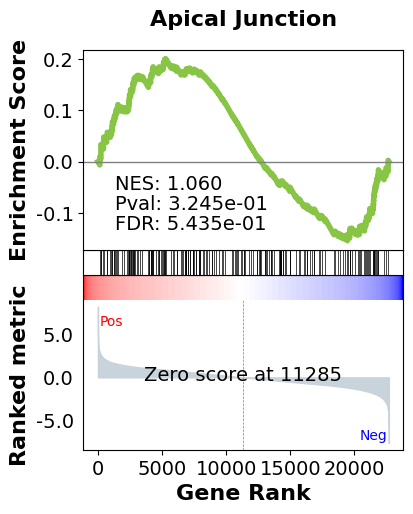

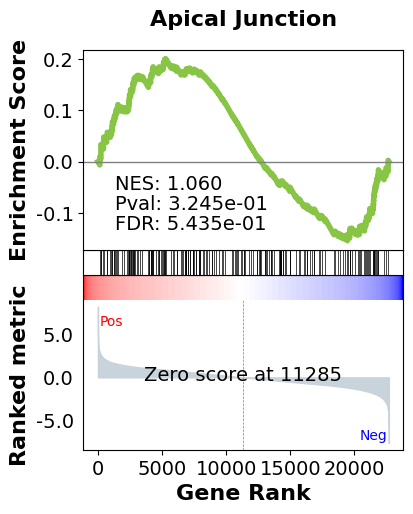

In [32]:
terms = gsea_2d.res2d['Term'].tolist()

# Plot the 10th pathway (index 9)
gsea_2d.plot(terms=terms[32])

Cell 10: Run GSEA - 3D Fullerene

In [11]:
print("="*60)
print("RUNNING GSEA: 3D FULLERENE")
print("="*60)

gsea_3d = gp.prerank(
    rnk="kinaret_3D_fullerene_vs_control.rnk",
    gene_sets="MSigDB_Hallmark_2020",
    outdir="gsea_kinaret_3D_fullerene",
    min_size=15,
    max_size=500,
    permutation_num=1000,
    seed=42,
    threads=4,
    format="png",
    verbose=True
)

print("✅ GSEA complete for 3D Fullerene")

2025-11-12 19:39:04,395 [INFO] Parsing data files for GSEA.............................
2025-11-12 19:39:04,431 [INFO] Enrichr library gene sets already downloaded in: /root/.cache/gseapy, use local file
2025-11-12 19:39:04,445 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=15
2025-11-12 19:39:04,446 [INFO] 0050 gene_sets used for further statistical testing.....
2025-11-12 19:39:04,448 [INFO] Start to run GSEA...Might take a while..................


RUNNING GSEA: 3D FULLERENE


2025-11-12 19:39:20,187 [INFO] Congratulations. GSEApy runs successfully................



✅ GSEA complete for 3D Fullerene


In [33]:
gsea_3d.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,E2F Targets,0.416061,1.995478,0.0,0.0,0.0,59/185,15.62%,NASP;KIF22;AURKB;MYBL2;KIF2C;PRDX4;ASF1B;PTTG1...
1,prerank,G2-M Checkpoint,0.352261,1.696896,0.001931,0.016706,0.023,58/182,21.53%,NASP;KIF22;AURKB;MYBL2;E2F1;KIF2C;PTTG1;NDC80;...
2,prerank,Spermatogenesis,0.338784,1.545876,0.00409,0.064888,0.125,43/130,20.68%,ZNRF4;KIF2C;TEKT2;HOXB1;TTK;CAMK4;TALDO1;ACRBP...
3,prerank,Protein Secretion,-0.350637,-1.516058,0.001942,0.114358,0.188,37/95,27.31%,STX12;CLTC;MON2;EGFR;VAMP3;STX16;SEC22B;GOSR2;...
4,prerank,Interferon Alpha Response,0.349932,1.503206,0.012048,0.0799,0.197,35/92,27.94%,TMEM140;TRIM25;RTP4;IFITM1;IRF1;PSMA3;TDRD7;PS...
5,prerank,Pperoxisome,0.325309,1.406291,0.028866,0.158347,0.414,26/100,16.52%,MVP;ACOX1;ESR2;SLC27A2;ABCC8;CACNA1B;TOP2A;PRD...
6,prerank,mTORC1 Signaling,0.289066,1.402544,0.008147,0.136072,0.423,52/191,22.21%,NUPR1;FADS2;GBE1;DHFR;DDIT4;CFP;GGA2;MCM2;SLC1...
7,prerank,IL-6/JAK/STAT3 Signaling,-0.323769,-1.384281,0.033663,0.179032,0.461,32/87,26.16%,IL13RA1;IL7;DNTT;CBL;IFNGR2;IL1R2;PTPN1;STAT3;...
8,prerank,Oxidative Phosphorylation,0.288651,1.381016,0.012397,0.138009,0.481,80/180,32.71%,PDK4;HADHA;UQCRQ;POR;NDUFA1;COX15;MRPL11;NDUFA...
9,prerank,Reactive Oxygen Species Pathway,0.35482,1.32551,0.094538,0.200839,0.654,18/45,24.95%,NQO1;PRDX4;FTL;HMOX2;PRDX1;NDUFS2;TXNRD2;NDUFB...


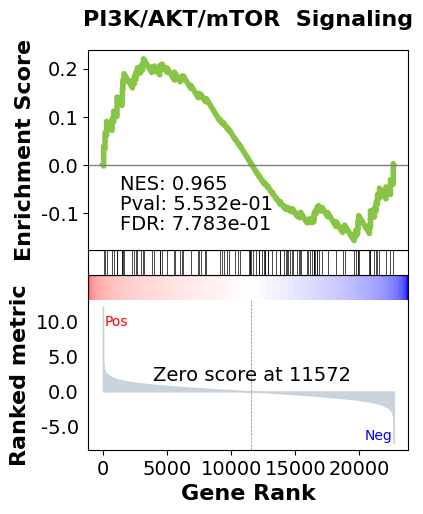

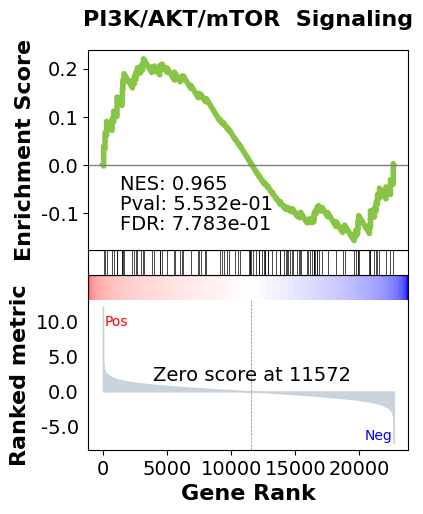

In [34]:
terms = gsea_3d.res2d['Term'].tolist()

# Plot the 10th pathway (index 9)
gsea_3d.plot(terms=terms[32])

Cell 11: Extract and Compare Results

In [12]:
print("="*60)
print("EXTRACTING AND COMPARING RESULTS")
print("="*60)

# Extract results
res_2d = gsea_2d.res2d[['Term', 'NES', 'NOM p-val', 'FDR q-val']].copy()
res_2d['Material'] = '2D_Graphene'
res_2d['Dimensionality'] = '2D'

res_3d = gsea_3d.res2d[['Term', 'NES', 'NOM p-val', 'FDR q-val']].copy()
res_3d['Material'] = '3D_Fullerene'
res_3d['Dimensionality'] = '3D'

# Filter for significant pathways (FDR < 0.25)
sig_2d = res_2d[res_2d['FDR q-val'] < 0.25].copy()
sig_3d = res_3d[res_3d['FDR q-val'] < 0.25].copy()

print(f"\nSignificant pathways (FDR < 0.25):")
print(f"  2D Graphene:  {len(sig_2d)}")
print(f"  3D Fullerene: {len(sig_3d)}")

# Find overlapping pathways
sig_terms_2d = set(sig_2d['Term'])
sig_terms_3d = set(sig_3d['Term'])

overlap = sig_terms_2d & sig_terms_3d
only_2d = sig_terms_2d - sig_terms_3d
only_3d = sig_terms_3d - sig_terms_2d

print(f"\nPathway overlap analysis:")
print(f"  Shared (both 2D and 3D):  {len(overlap)}")
print(f"  2D-specific (graphene):   {len(only_2d)}")
print(f"  3D-specific (fullerene):  {len(only_3d)}")

# Calculate overlap percentage
total_unique = len(sig_terms_2d | sig_terms_3d)
overlap_pct = (len(overlap) / total_unique * 100) if total_unique > 0 else 0
print(f"  Overlap percentage:       {overlap_pct:.1f}%")

EXTRACTING AND COMPARING RESULTS

Significant pathways (FDR < 0.25):
  2D Graphene:  16
  3D Fullerene: 10

Pathway overlap analysis:
  Shared (both 2D and 3D):  6
  2D-specific (graphene):   10
  3D-specific (fullerene):  4
  Overlap percentage:       30.0%


Cell 12: Analyze Shared Pathways

In [19]:
print("="*60)
print("SHARED BIOLOGICAL RESPONSES (2D and 3D)")
print("="*60)

if len(overlap) > 0:
    shared_analysis = []

    for term in overlap:
        nes_2d = sig_2d[sig_2d['Term'] == term]['NES'].values[0]
        nes_3d = sig_3d[sig_3d['Term'] == term]['NES'].values[0]

        fdr_2d = sig_2d[sig_2d['Term'] == term]['FDR q-val'].values[0]
        fdr_3d = sig_3d[sig_3d['Term'] == term]['FDR q-val'].values[0]

        # Check direction
        same_direction = (nes_2d > 0 and nes_3d > 0) or (nes_2d < 0 and nes_3d < 0)

        shared_analysis.append({
            'Term': term,
            'NES_2D': nes_2d,
            'NES_3D': nes_3d,
            'FDR_2D': fdr_2d,
            'FDR_3D': fdr_3d,
            'Same_Direction': same_direction,
            'Avg_NES': (abs(nes_2d) + abs(nes_3d)) / 2
        })

    shared_df = pd.DataFrame(shared_analysis)
    shared_df = shared_df.sort_values('Avg_NES', ascending=False)

    print(f"\nTop 10 shared pathways (by average |NES|):")
    print("-"*80)
    for idx, row in shared_df.head(10).iterrows():
        direction = "✅ SAME" if row['Same_Direction'] else "⚠️ OPPOSITE"
        print(f"{row['Term'][:50]:50s}")
        print(f"  2D: NES={row['NES_2D']:6.2f} (FDR={row['FDR_2D']:.4f})  |  " +
              f"3D: NES={row['NES_3D']:6.2f} (FDR={row['FDR_3D']:.4f})  [{direction}]")

    # Calculate NES correlation
    corr = np.corrcoef(shared_df['NES_2D'], shared_df['NES_3D'])[0, 1]
    print(f"\n📊 NES Correlation for shared pathways: r = {corr:.3f}")

    if corr > 0.7:
        print("   ✅ Strong positive correlation - similar mechanisms")
    elif corr > 0.4:
        print("   ⚠️ Moderate correlation - partially similar mechanisms")
    else:
        print("   ❌ Weak correlation - different mechanisms")

    # Save shared pathways
    shared_df.to_csv("kinaret_2D_vs_3D_shared_pathways.csv", index=False)
    print("\n✅ Saved: kinaret_2D_vs_3D_shared_pathways.csv")
else:
    print("⚠️ No shared pathways found (FDR < 0.25)")
    shared_df = None
    corr = None

SHARED BIOLOGICAL RESPONSES (2D and 3D)

Top 10 shared pathways (by average |NES|):
--------------------------------------------------------------------------------
E2F Targets                                       
  2D: NES= -2.81 (FDR=0.0000)  |  3D: NES=  2.00 (FDR=0.0000)  [⚠️ OPPOSITE]
G2-M Checkpoint                                   
  2D: NES= -2.33 (FDR=0.0000)  |  3D: NES=  1.70 (FDR=0.0167)  [⚠️ OPPOSITE]
Interferon Alpha Response                         
  2D: NES=  1.54 (FDR=0.0708)  |  3D: NES=  1.50 (FDR=0.0799)  [✅ SAME]
mTORC1 Signaling                                  
  2D: NES= -1.52 (FDR=0.0474)  |  3D: NES=  1.40 (FDR=0.1361)  [⚠️ OPPOSITE]
Protein Secretion                                 
  2D: NES= -1.39 (FDR=0.0946)  |  3D: NES= -1.52 (FDR=0.1144)  [✅ SAME]
Oxidative Phosphorylation                         
  2D: NES= -1.43 (FDR=0.0783)  |  3D: NES=  1.38 (FDR=0.1380)  [⚠️ OPPOSITE]

📊 NES Correlation for shared pathways: r = -0.071
   ❌ Weak correlation - di

Cell 13: Display Material-Specific Pathways

In [13]:
print("="*60)
print("MATERIAL-SPECIFIC RESPONSES")
print("="*60)

if len(only_2d) > 0:
    print(f"\n2D-SPECIFIC PATHWAYS (Graphene only, n={len(only_2d)}):")
    print("-"*60)
    for term in list(only_2d)[:10]:
        nes = sig_2d[sig_2d['Term'] == term]['NES'].values[0]
        fdr = sig_2d[sig_2d['Term'] == term]['FDR q-val'].values[0]
        direction = "↑" if nes > 0 else "↓"
        print(f"  {direction} {term[:55]:55s}  NES={nes:6.2f}  FDR={fdr:.4f}")

if len(only_3d) > 0:
    print(f"\n3D-SPECIFIC PATHWAYS (Fullerene only, n={len(only_3d)}):")
    print("-"*60)
    for term in list(only_3d)[:10]:
        nes = sig_3d[sig_3d['Term'] == term]['NES'].values[0]
        fdr = sig_3d[sig_3d['Term'] == term]['FDR q-val'].values[0]
        direction = "↑" if nes > 0 else "↓"
        print(f"  {direction} {term[:55]:55s}  NES={nes:6.2f}  FDR={fdr:.4f}")

MATERIAL-SPECIFIC RESPONSES

2D-SPECIFIC PATHWAYS (Graphene only, n=10):
------------------------------------------------------------
  ↓ Wnt-beta Catenin Signaling                               NES= -1.32  FDR=0.1537
  ↓ Bile Acid Metabolism                                     NES= -1.33  FDR=0.1453
  ↓ Myc Targets V1                                           NES= -1.74  FDR=0.0102
  ↓ TNF-alpha Signaling via NF-kB                            NES= -1.53  FDR=0.0528
  ↓ Androgen Response                                        NES= -1.52  FDR=0.0429
  ↓ Apoptosis                                                NES= -1.51  FDR=0.0420
  ↓ UV Response Dn                                           NES= -1.40  FDR=0.0987
  ↓ Adipogenesis                                             NES= -1.73  FDR=0.0114
  ↓ Fatty Acid Metabolism                                    NES= -1.87  FDR=0.0041
  ↓ Unfolded Protein Response                                NES= -1.55  FDR=0.0522

3D-SPECIFIC PATHWAYS (Ful

Cell 14: Visualization - NES Correlation Scatter Plot

✅ Saved: kinaret_2D_vs_3D_NES_correlation.png


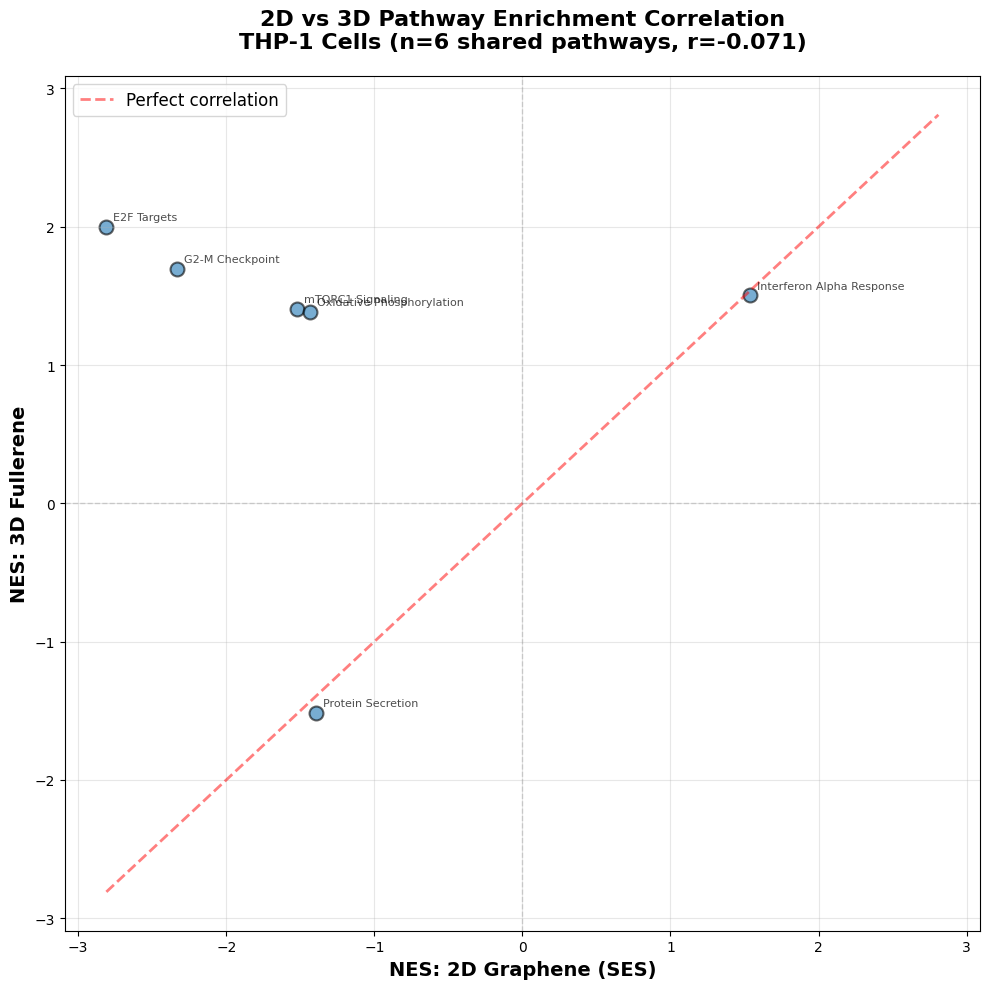

In [20]:
if len(overlap) > 0 and shared_df is not None:
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(shared_df['NES_2D'], shared_df['NES_3D'],
               s=100, alpha=0.6, edgecolors='black', linewidth=1.5)

    # Add diagonal line
    lim = max(abs(shared_df['NES_2D'].max()), abs(shared_df['NES_3D'].max()),
              abs(shared_df['NES_2D'].min()), abs(shared_df['NES_3D'].min()))
    ax.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.5, linewidth=2, label='Perfect correlation')

    # Add labels for top pathways
    for idx, row in shared_df.head(8).iterrows():
        ax.annotate(row['Term'][:30],
                   (row['NES_2D'], row['NES_3D']),
                   fontsize=8, alpha=0.7,
                   xytext=(5, 5), textcoords='offset points')

    ax.set_xlabel('NES: 2D Graphene (SES)', fontsize=14, fontweight='bold')
    ax.set_ylabel('NES: 3D Fullerene', fontsize=14, fontweight='bold')
    ax.set_title(f'2D vs 3D Pathway Enrichment Correlation\n' +
                 f'THP-1 Cells (n={len(overlap)} shared pathways, r={corr:.3f})',
                 fontsize=16, fontweight='bold', pad=20)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig('kinaret_2D_vs_3D_NES_correlation.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: kinaret_2D_vs_3D_NES_correlation.png")
    plt.show()

✅ Saved: kinaret_2D_vs_3D_heatmap.png


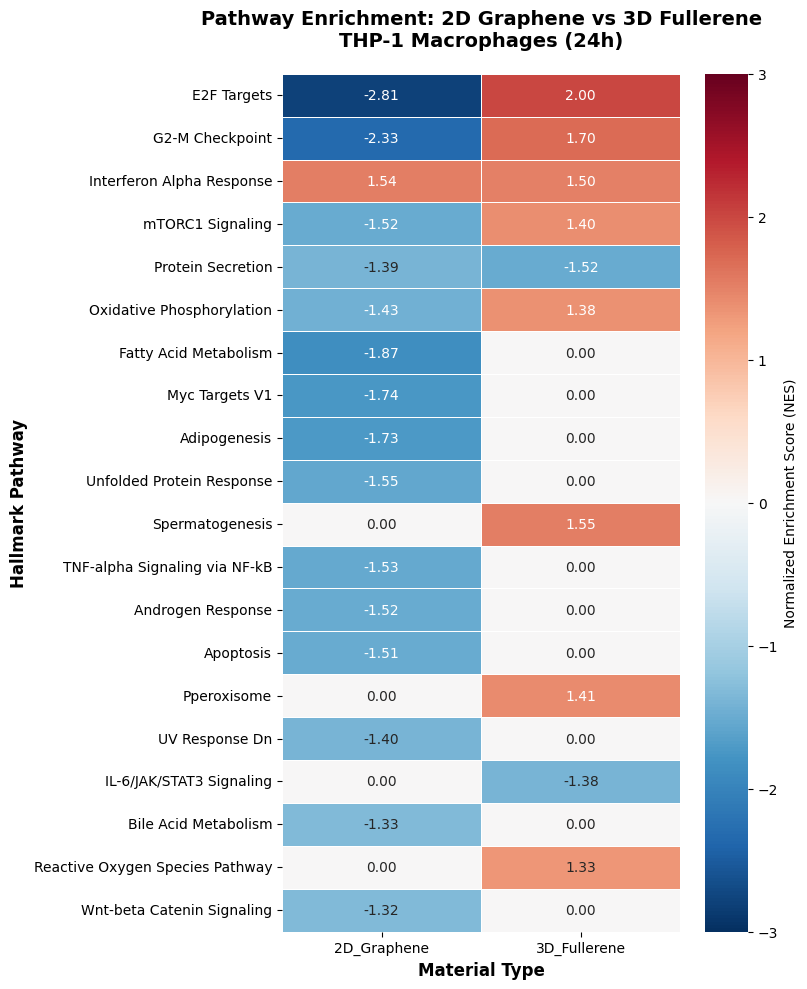

In [21]:
# Cell 15: Visualization - Heatmap

# Prepare heatmap data
all_sig_terms = sorted(list(sig_terms_2d | sig_terms_3d))

if len(all_sig_terms) > 0:
    heatmap_data = []
    for term in all_sig_terms:
        row = {'Term': term}

        if term in sig_2d['Term'].values:
            row['2D_Graphene'] = sig_2d[sig_2d['Term'] == term]['NES'].values[0]
        else:
            row['2D_Graphene'] = 0

        if term in sig_3d['Term'].values:
            row['3D_Fullerene'] = sig_3d[sig_3d['Term'] == term]['NES'].values[0]
        else:
            row['3D_Fullerene'] = 0

        heatmap_data.append(row)

    heatmap_df = pd.DataFrame(heatmap_data).set_index('Term')

    # Sort by average absolute NES
    heatmap_df['avg_abs_nes'] = (heatmap_df['2D_Graphene'].abs() +
                                  heatmap_df['3D_Fullerene'].abs()) / 2
    heatmap_df = heatmap_df.sort_values('avg_abs_nes', ascending=False)
    heatmap_df = heatmap_df.drop('avg_abs_nes', axis=1)

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(8, max(10, len(all_sig_terms) * 0.35)))
    sns.heatmap(heatmap_df, cmap='RdBu_r', center=0, vmin=-3, vmax=3,
                annot=True, fmt='.2f',
                cbar_kws={'label': 'Normalized Enrichment Score (NES)'},
                linewidths=0.5, ax=ax)
    ax.set_title('Pathway Enrichment: 2D Graphene vs 3D Fullerene\nTHP-1 Macrophages (24h)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Material Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Hallmark Pathway', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('kinaret_2D_vs_3D_heatmap.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: kinaret_2D_vs_3D_heatmap.png")
    plt.show()
else:
    print("⚠️ No significant pathways found in either material")

✅ Saved: kinaret_2D_vs_3D_venn.png


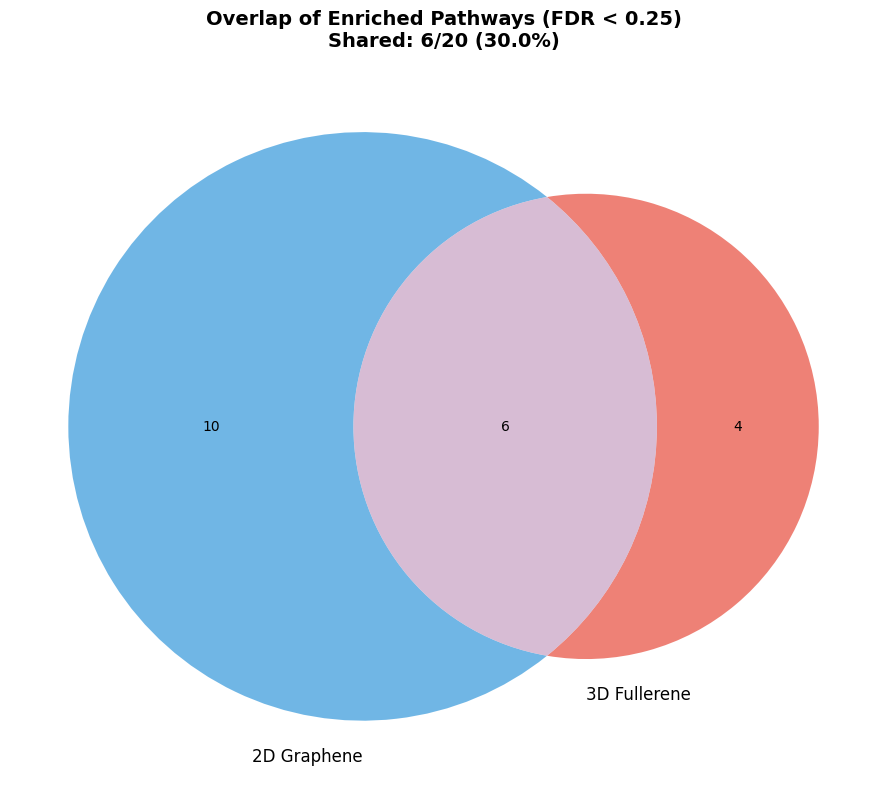

In [18]:
try:
    from matplotlib_venn import venn2

    fig, ax = plt.subplots(figsize=(10, 8))
    venn2([sig_terms_2d, sig_terms_3d],
          set_labels=('2D Graphene', '3D Fullerene'),
          set_colors=('#3498db', '#e74c3c'),
          alpha=0.7,
          ax=ax)
    ax.set_title(f'Overlap of Enriched Pathways (FDR < 0.25)\n' +
                 f'Shared: {len(overlap)}/{total_unique} ({overlap_pct:.1f}%)',
                 fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('kinaret_2D_vs_3D_venn.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: kinaret_2D_vs_3D_venn.png")
    plt.show()
except ImportError:
    print("⚠️ matplotlib_venn not installed - skipping Venn diagram")
    print("   Install with: !pip install matplotlib-venn")

In [22]:
# ============================================================
# VERIFICATION: Are negative NES scores real?
# ============================================================

print("="*60)
print("VERIFICATION CHECKS")
print("="*60)

# Check 1: Verify t-statistic direction
print("\n[CHECK 1] T-statistic sign verification")
print("-"*60)

# Look at top positive gene (should be UP in graphene)
top_up_gene = rnk_ses.iloc[0]['gene']
print(f"Top UPREGULATED gene: {top_up_gene}")
print(f"  t-statistic: {rnk_ses.iloc[0]['score']:.3f}")
print(f"  Control mean:  {grp_control_ses.loc[top_up_gene].mean():.3f}")
print(f"  Graphene mean: {grp_SES.loc[top_up_gene].mean():.3f}")
print(f"  Difference:    {grp_SES.loc[top_up_gene].mean() - grp_control_ses.loc[top_up_gene].mean():.3f}")
if rnk_ses.iloc[0]['score'] > 0:
    if grp_SES.loc[top_up_gene].mean() > grp_control_ses.loc[top_up_gene].mean():
        print("  ✅ CORRECT: Positive t-stat, graphene > control")
    else:
        print("  ❌ ERROR: Sign is backwards!")

# Look at bottom negative gene (should be DOWN in graphene)
top_down_gene = rnk_ses.iloc[-1]['gene']
print(f"\nTop DOWNREGULATED gene: {top_down_gene}")
print(f"  t-statistic: {rnk_ses.iloc[-1]['score']:.3f}")
print(f"  Control mean:  {grp_control_ses.loc[top_down_gene].mean():.3f}")
print(f"  Graphene mean: {grp_SES.loc[top_down_gene].mean():.3f}")
print(f"  Difference:    {grp_SES.loc[top_down_gene].mean() - grp_control_ses.loc[top_down_gene].mean():.3f}")
if rnk_ses.iloc[-1]['score'] < 0:
    if grp_SES.loc[top_down_gene].mean() < grp_control_ses.loc[top_down_gene].mean():
        print("  ✅ CORRECT: Negative t-stat, graphene < control")
    else:
        print("  ❌ ERROR: Sign is backwards!")

# Check 2: Overall expression comparison
print("\n[CHECK 2] Overall Expression Levels")
print("-"*60)
ctrl_overall = grp_control_ses.mean().mean()
ses_overall = grp_SES.mean().mean()
print(f"Control mean expression:  {ctrl_overall:.3f}")
print(f"Graphene mean expression: {ses_overall:.3f}")
print(f"Difference (Graphene - Control): {ses_overall - ctrl_overall:.3f}")

if ses_overall < ctrl_overall:
    print("  ⚠️ Graphene has LOWER overall expression than control")
    print("  This could indicate:")
    print("    - Global transcriptional suppression")
    print("    - Cell death/RNA degradation")
    print("    - Cells entering quiescence")

# Check 3: Sample quality (replicates should correlate)
print("\n[CHECK 3] Sample Correlation (Quality Check)")
print("-"*60)
from scipy.stats import pearsonr

# Control-Control correlations
ctrl_corrs = []
for i in range(len(negCont_samples)):
    for j in range(i+1, len(negCont_samples)):
        corr = pearsonr(grp_control_ses.iloc[:, i], grp_control_ses.iloc[:, j])[0]
        ctrl_corrs.append(corr)

# SES-SES correlations
ses_corrs = []
for i in range(len(SES_samples)):
    for j in range(i+1, len(SES_samples)):
        corr = pearsonr(grp_SES.iloc[:, i], grp_SES.iloc[:, j])[0]
        ses_corrs.append(corr)

print(f"Control-Control correlation: {np.mean(ctrl_corrs):.3f}")
print(f"Graphene-Graphene correlation: {np.mean(ses_corrs):.3f}")

if np.mean(ctrl_corrs) > 0.95 and np.mean(ses_corrs) > 0.95:
    print("  ✅ Replicates are highly correlated - good quality")
elif np.mean(ses_corrs) < 0.85:
    print("  ⚠️ Graphene replicates have low correlation - check data quality")

# Check 4: Are cells dying?
print("\n[CHECK 4] Cell Viability Markers")
print("-"*60)

# Apoptosis markers (if UP = cells dying)
apoptosis_genes = ['BAX', 'BCL2', 'CASP3', 'CASP8', 'CASP9', 'FAS', 'FASLG']
print("Apoptosis genes:")
apoptosis_changes = []
for gene in apoptosis_genes:
    if gene in subset_ses.index:
        ctrl_mean = grp_control_ses.loc[gene].mean()
        ses_mean = grp_SES.loc[gene].mean()
        fold_change = ses_mean - ctrl_mean
        apoptosis_changes.append(fold_change)
        direction = "↑" if fold_change > 0 else "↓"
        print(f"  {gene:8s}: {direction} {fold_change:+6.2f}")

if len(apoptosis_changes) > 0 and np.mean(apoptosis_changes) > 0.5:
    print("\n  ⚠️ Apoptosis markers are ELEVATED - cells may be dying")
elif len(apoptosis_changes) > 0 and np.mean(apoptosis_changes) < 0:
    print("\n  ✅ Apoptosis markers are NOT elevated - cells are viable")

# Housekeeping genes (should be stable)
housekeeping = ['ACTB', 'GAPDH', 'B2M', 'HPRT1', 'TBP']
print("\nHousekeeping genes (should be stable):")
for gene in housekeeping:
    if gene in subset_ses.index:
        ctrl_mean = grp_control_ses.loc[gene].mean()
        ses_mean = grp_SES.loc[gene].mean()
        fold_change = ses_mean - ctrl_mean
        print(f"  {gene:8s}: {fold_change:+6.2f}")

# Check 5: Compare to Fullerene (sanity check)
print("\n[CHECK 5] Compare to Fullerene (Sanity Check)")
print("-"*60)

# Count positive vs negative NES
graphene_up = (sig_2d['NES'] > 0).sum()
graphene_down = (sig_2d['NES'] < 0).sum()
fullerene_up = (sig_3d['NES'] > 0).sum()
fullerene_down = (sig_3d['NES'] < 0).sum()

print(f"2D Graphene significant pathways:")
print(f"  Upregulated (NES > 0):   {graphene_up}/{len(sig_2d)} ({graphene_up/len(sig_2d)*100:.0f}%)")
print(f"  Downregulated (NES < 0): {graphene_down}/{len(sig_2d)} ({graphene_down/len(sig_2d)*100:.0f}%)")

print(f"\n3D Fullerene significant pathways:")
print(f"  Upregulated (NES > 0):   {fullerene_up}/{len(sig_3d)} ({fullerene_up/len(sig_3d)*100:.0f}%)")
print(f"  Downregulated (NES < 0): {fullerene_down}/{len(sig_3d)} ({fullerene_down/len(sig_3d)*100:.0f}%)")

if graphene_down > graphene_up and fullerene_up > fullerene_down:
    print("\n  ✅ Pattern makes sense: Graphene suppressive, Fullerene activating")
    print("  This supports REAL biological difference, not technical artifact")

# Check 6: Look at E2F target genes directly
print("\n[CHECK 6] E2F Target Genes (Cell Cycle)")
print("-"*60)
e2f_genes = ['E2F1', 'CCNE1', 'CCNA2', 'CDC6', 'MCM2', 'PCNA']
print("Key E2F target genes:")
for gene in e2f_genes:
    if gene in subset_ses.index:
        ctrl_mean = grp_control_ses.loc[gene].mean()
        ses_mean = grp_SES.loc[gene].mean()
        fold_change = ses_mean - ctrl_mean
        direction = "↑" if fold_change > 0 else "↓"
        print(f"  {gene:8s}: {direction} {fold_change:+6.2f}")

print("\n" + "="*60)
print("VERIFICATION COMPLETE")
print("="*60)

VERIFICATION CHECKS

[CHECK 1] T-statistic sign verification
------------------------------------------------------------
Top UPREGULATED gene: HEPH
  t-statistic: 8.246
  Control mean:  7.120
  Graphene mean: 7.370
  Difference:    0.249
  ✅ CORRECT: Positive t-stat, graphene > control

Top DOWNREGULATED gene: DNAJC3
  t-statistic: -7.631
  Control mean:  10.571
  Graphene mean: 9.911
  Difference:    -0.660
  ✅ CORRECT: Negative t-stat, graphene < control

[CHECK 2] Overall Expression Levels
------------------------------------------------------------
Control mean expression:  8.825
Graphene mean expression: 8.839
Difference (Graphene - Control): 0.014

[CHECK 3] Sample Correlation (Quality Check)
------------------------------------------------------------
Control-Control correlation: 0.982
Graphene-Graphene correlation: 0.947

[CHECK 4] Cell Viability Markers
------------------------------------------------------------
Apoptosis genes:
  BAX     : ↑  +0.24
  BCL2    : ↓  -0.13
  CA